In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from dfdb import DFDB

import numpy as np
from sklearn.decomposition import PCA

import types
import copy


import numpy as np
from sklearn.manifold import TSNE


Using TensorFlow backend.


In [2]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_colwidth', -1)

In [4]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [5]:
df_spec_train = pd.read_pickle('../feats/spec_features.pkl')
df_spec_test = pd.read_pickle('../feats/spec_features_test.pkl')

In [6]:
df_train = pd.merge(df_train, df_spec_train, on='index')
df_test = pd.merge(df_test, df_spec_test, on='index')

In [7]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [8]:
len(tsfresh_columns)

9731

In [9]:
top200 =['spkt_welch_densitycoeff_2',
 'spkt_welch_density__coeff_3',
 'q25_roll_std_100',
 '3th_peak_freq',
 'min_roll_std_100',
 'q05_roll_std_100',
 'iqr_6',
 'abs_max_8',
 'mfcc_5_abs_mean',
 "number_peaks{'n': 10}",
 'ave10_7',
 'mfcc_13_mean',
 "autocorrelation{'lag': 5}",
 'mfcc_accelerate_8_variance',
 'abs_max_7',
 'mfcc_accelerate_1_kurtosis',
 'q05_roll_std_1000',
 'spkt_welch_density__coeff_42',
 'max_to_min_diff_5',
 'mfcc_13_quantile25',
 'fft_coefficientcoeff_80__attr_"imag"',
 'abs_q25_5',
 'mfcc_5_mean',
 'median__roll_std',
 '5000skewness_max_',
 'fft_coefficientcoeff_6__attr_"abs"',
 'partial_autocorrelationlag_5',
 'abs_min_8',
 'spkt_welch_density__coeff_28',
 'ar_coefficientk_10__coeff_3',
 'abs_q75_7',
 'mfcc_accelerate_15_min',
 'abs_max_4',
 'mfcc_10_quantile25',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_density__coeff_79',
 "value_count{'value': 1}",
 '5000peak_peak_amp_max_',
 'min__roll_std',
 'mfcc_4_rolling_std_mean',
 'q01_roll_std_1000',
 'mfcc_3_abs_q75',
 'mfcc_5_quantile95',
 'fft_coefficientcoeff_16__attr_"imag"',
 'abs_q01_4',
 'mfcc_6_quantile05',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 '5000quantile25skewness_',
 'mfcc_0_abs_q25',
 'mfcc_delta_3_quantile01',
 'spkt_welch_density__coeff_99',
 'mfcc_9_mean',
 'mfcc_12_mean',
 'q75_roll_mean_10',
 'max_to_min',
 'mfcc_3_abs_mean',
 'kurt_7',
 'mfcc_14_quantile01',
 'mfcc_10_mean',
 'mfcc_delta_13_min',
 'mfcc_delta_13_abs_max',
 '5000no_zero_crossing_mean_',
 'abs_q75_6',
 'mfcc_12_quantile99',
 'mfcc_accelerate_6_skewness',
 'mfcc_5_max',
 '5000smoothness_entropy_',
 '5000median_skewness_',
 'mfcc_accelerate_8_min',
 'abs_min_3',
 '5000quantile75mean_',
 "number_crossing_m{'m': 1}",
 '5000smoothness_std_',
 'mfcc_9_abs_q25',
 'flac3_1_quantile99',
 'mfcc_5_skewness',
 'fft_coefficientcoeff_56__attr_"angle"',
 'fft_coefficientcoeff_70__attr_"abs"',
 'mfcc_10_abs_q75',
 'fft_coefficientcoeff_24__attr_"angle"',
 'med_7',
 'spkt_welch_density__coeff_73',
 'abs_q99_8',
 'ave10_6',
 'spkt_welch_density__coeff_38',
 'skew_1',
 'mfcc_delta_3_abs_q95',
 "change_quantiles{'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}",
 'max_to_min_5',
 'mfcc_delta_4_quantile75',
 'abs_max_1',
 '5000crest_factor_quantile75',
 'partial_autocorrelationlag_1',
 'mfcc_delta_11_quantile01',
 'mfcc_accelerate_7_quantile01',
 'mfcc_8_rolling_std_mean',
 'q95_roll_mean_100',
 'mfcc_delta_6_rolling_std_mean',
 'flac3_0_min',
 'fft_coefficientcoeff_36__attr_"abs"',
 'iqr_8',
 'max_9',
 '5000smoothness_quantile05',
 'mfcc_1_kurtosis',
 'mfcc_7_abs_q95',
 'spkt_welch_density__coeff_66',
 'spkt_welch_density__coeff_64',
 'mfcc_3_abs_q95',
 '5000skewness_mean_',
 'mfcc_10_abs_mean',
 '5000quantile99quantile01',
 'mean_change_rate',
 'mfcc_accelerate_5_rolling_std_mean',
 'mfcc_accelerate_5_quantile05',
 '5000rms_median_',
 'flac3_1_abs_mean',
 '5000rms_quantile05',
 '5000quantile75quantile25',
 'mfcc_accelerate_12_min',
 "value_count{'value': -1}",
 'mfcc_12_abs_max',
 'abs_min_5',
 'mfcc_5_abs_q99',
 'mfcc_delta_5_quantile01',
 'mfcc_12_quantile75',
 'fft_coefficientcoeff_56__attr_"imag"',
 'spkt_welch_densitycoeff_5',
 'mfcc_0_abs_q05',
 'mfcc_13_quantile75',
 'mfcc_delta_5_min',
 'mfcc_5_quantile99',
 'fft_coefficientcoeff_8__attr_"angle"',
 'spkt_welch_density__coeff_30',
 'mfcc_accelerate_4_max',
 'mfcc_14_median',
 "change_quantiles{'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'}",
 'mfcc_5_median',
 'mfcc_accelerate_5_abs_q75',
 'spkt_welch_density__coeff_59',
 'mfcc_accelerate_5_kurtosis',
 'mfcc_delta_9_quantile99',
 'mfcc_5_quantile25',
 'spkt_welch_density__coeff_113',
 'mfcc_2_quantile05',
 'spkt_welch_density__coeff_58',
 'mfcc_5_abs_q75',
 'spkt_welch_density__coeff_22',
 'spkt_welch_density__coeff_115',
 'spkt_welch_density__coeff_4',
 'mfcc_5_abs_q05',
 'spkt_welch_density__coeff_25',
 'mfcc_5_abs_max',
 'spkt_welch_density__coeff_27',
 'mfcc_4_quantile75',
 'mfcc_3_rolling_std_mean',
 'mfcc_4_median',
 'mfcc_0_quantile01',
 '5000quantile75rssq_',
 'fft_coefficientcoeff_24__attr_"imag"',
 'mfcc_delta_12_kurtosis',
 '5000rms_quantile25',
 'mfcc_13_quantile05',
 'fft_coefficientcoeff_8__attr_"imag"',
 'mfcc_delta_11_rolling_std_mean',
 'mfcc_delta_12_quantile99',
 'mfcc_accelerate_9_abs_q25',
 'mfcc_11_abs_mean',
 'mfcc_delta_15_abs_max',
 'abs_max_2',
 'mfcc_11_abs_std',
 'abs_max_roll_mean_1000',
 'peak_to_average_power_ratio__roll_mean',
 'mfcc_13_median',
 'fft_coefficientcoeff_62__attr_"abs"',
 'mfcc_11_quantile75',
 "quantile{'q': 0.8}",
 'mfcc_delta_3_rolling_std_mean',
 'abs_q99_7',
 'mfcc_delta_12_max',
 'mfcc_12_min',
 'mfcc_10_quantile99',
 'mfcc_14_abs_q99',
 'mfcc_14_quantile05',
 'mfcc_14_quantile25',
 'kurt_1',
 'mfcc_2_median',
 'q01_2',
 'mfcc_2_abs_q25',
 'kurt_8',
 'mfcc_accelerate_6_abs_max',
 'mfcc_1_quantile75',
 'q05_5',
 'abs_q95_9',
 'q05_roll_mean_100',
 'mfcc_10_abs_q25',
 'q75_9',
 'mfcc_15_mean',
 "change_quantiles{'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'}",
 'flac3_0_abs_std',
 "change_quantiles{'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}"]

In [15]:
X = np.concatenate([df_train[top200].values, df_test[top200].values],axis=0)
X_norm = StandardScaler().fit_transform(X)
X_embedded = TSNE(n_components=3).fit_transform(X_norm)

In [16]:
df_train.shape[0],df_test.shape[0]

(33426, 2624)

In [18]:
X_embedded[:33426].shape,X_embedded[33426:].shape

((33426, 3), (2624, 3))

In [19]:
df_train_tsne= pd.DataFrame()
df_train_tsne['index'] = df_train['index']
df_train_tsne['tsne_1'] = X_embedded[:33426][:,0]
df_train_tsne['tsne_2'] = X_embedded[:33426][:,1]
df_train_tsne['tsne_3'] = X_embedded[:33426][:,2]

In [24]:
df_test_tsne= pd.DataFrame()
df_test_tsne['index'] = df_test['index']
df_test_tsne['tsne_1'] = X_embedded[33426:][:,0]
df_test_tsne['tsne_2'] = X_embedded[33426:][:,1]
df_test_tsne['tsne_3'] = X_embedded[33426:][:,2]

In [23]:
df_train_tsne.head()

,index,tsne_1,tsne_2,tsne_3
0,0,-6.940755,-16.750292,4.457547
1,18750,-28.889744,-18.400795,-11.881632
2,37500,-28.896696,-18.410957,-11.892423
3,56250,-28.925600,-18.497824,-11.945592
4,75000,-29.187151,-19.312223,-12.453539


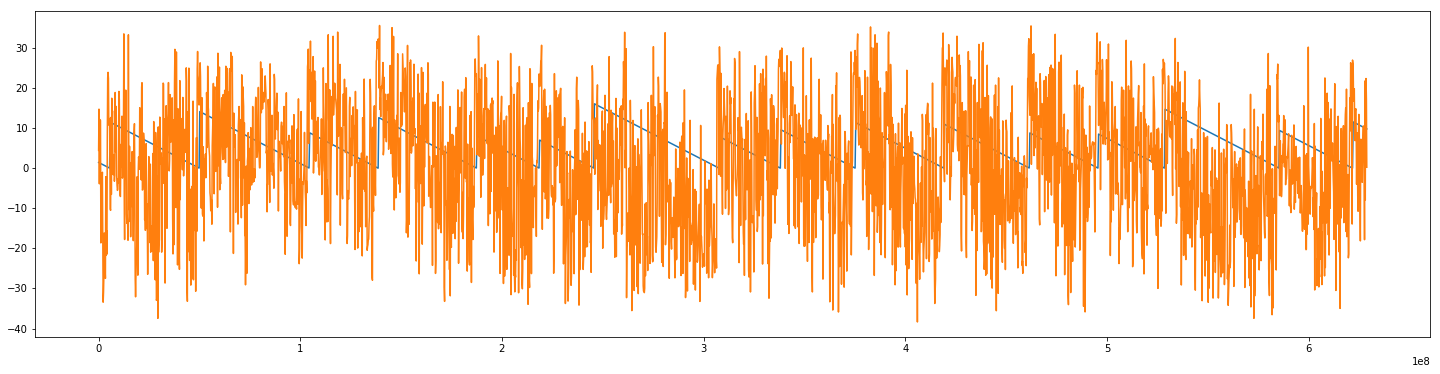

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(25, 6))
sns.lineplot(df_train['index'].values[::10], df_train['y'].values[::10])
sns.lineplot(df_train_tsne['index'].values[::10], df_train_tsne['tsne_1'].values[::10])
sns.lineplot(df_train_tsne['index'].values[::10], df_train_tsne['tsne_2'].values[::10])
sns.lineplot(df_train_tsne['index'].values[::10], df_train_tsne['tsne_3'].values[::10])

In [25]:
df_test_tsne.head()

,index,tsne_1,tsne_2,tsne_3
0,seg_00030f,-3.572744,0.941234,-20.830772
1,seg_0012b5,22.869949,-3.270394,-9.856074
2,seg_00184e,7.161292,-0.287662,15.383074
3,seg_003339,-19.149918,7.146243,1.320498
4,seg_0042cc,1.303808,20.638676,-17.199112


In [32]:
df_train_tsne.to_pickle('../feats/tsne.pkl')

In [33]:
df_test_tsne.to_pickle('../feats/tsne_test.pkl')

In [35]:
df_train_tsne.shape,df_test_tsne.shape

((33426, 4), (2624, 4))